# This is what we learned on HF RL Unit1 adjusted to use crypto market data



#### This code is based on the article 
https://www.section.io/engineering-education/leveraging-openai-gym-and-the-anytrading-environment-for-trading/

#### In this version I used PPO as a blackbox, I did not know how it works and I used the gym-anytrading, what was not a good env.

In [ ]:
# !pip install -r ./requirements.txt
!pip install stable_baselines3[extra]
!pip install yfinance
!pip install huggingface_sb3

In [6]:
import gym
from trading_env import TradingEnv

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv

from huggingface_sb3 import load_from_hub, package_to_hub, push_to_hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.

import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [3]:
# Get data
eth_usd = yf.Ticker("ETH-USD")
eth = eth_usd.history(period="max")
eth_train = eth[-300:-200]
eth_test = eth[-200:]

info {'total_reward': 174.176025390625, 'total_profit': 1.0512848550152105, 'position': 0}


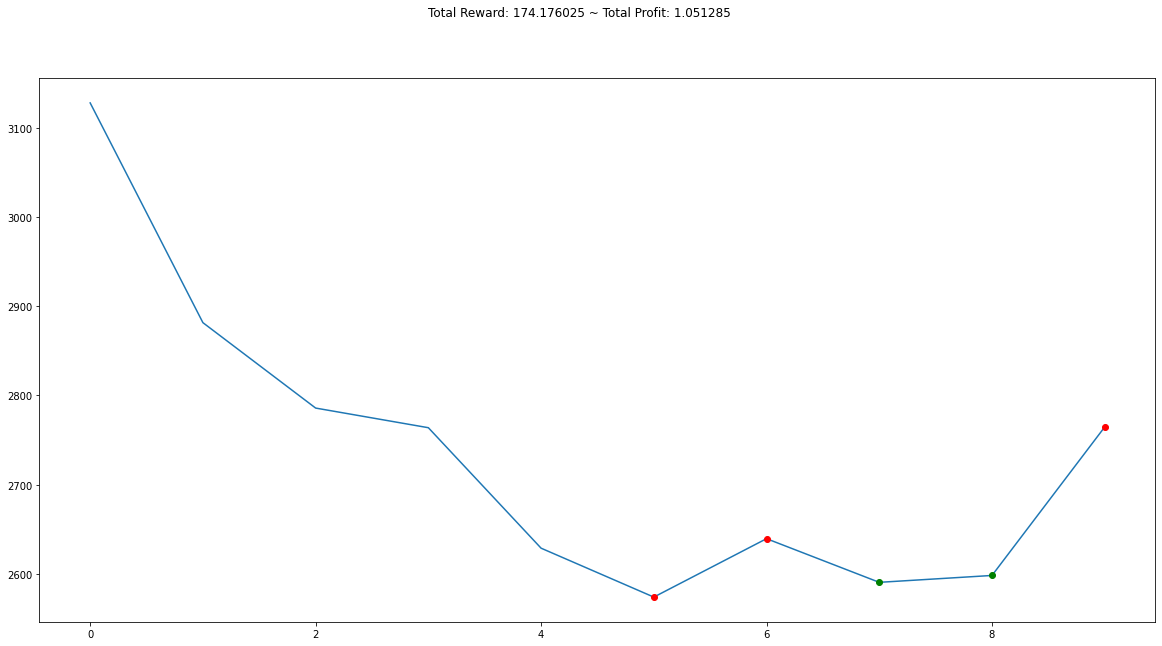

In [4]:
# do a simple test
env = TradingEnv(df=eth_train, frame_bound=(5,10), window_size=5)
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break

plt.figure(figsize=(20,10))
plt.cla()
env.render()
plt.show()

In [8]:
# create env
env_build = lambda: TradingEnv(df=eth_train, frame_bound=(30,len(eth_train)), window_size=30)
env = DummyVecEnv([env_build])

In [ ]:
# model_train = A2C('MlpPolicy', env, verbose=1) 

model_train = PPO(
    policy = 'MlpPolicy',
    env = env,
    n_steps = 1024,
    batch_size = 64,
    n_epochs = 4,
    gamma = 0.999,
    gae_lambda = 0.98,
    ent_coef = 0.01,
    verbose=1)

# model_train.learn(total_timesteps=10)
model_train.learn(total_timesteps=100000)

In [29]:
#testing
env = TradingEnv( df=eth_test, frame_bound=(30,len(eth_test)), window_size=30)
# env.trade_fee_ask_percent=0.0005 
# env.trade_fee_bid_percent=0.0005
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model_train.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 557.3472900390625, 'total_profit': 0.9569615163491025, 'position': 0}


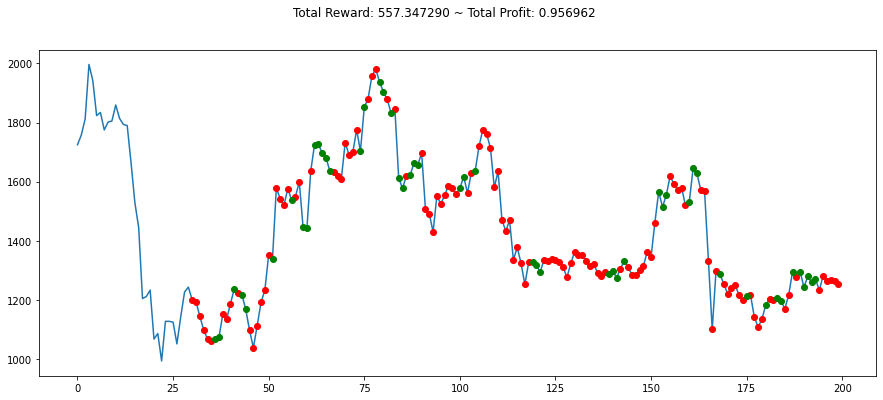

In [30]:
plt.figure(figsize=(15,6))
plt.cla()
env.render()
plt.show()

In [26]:
# Total profit > 1 win money,  < 1 lost money

In [7]:
# save to HF
notebook_login()
!git config --global credential.helper store

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
push_to_hub(
    repo_id="bonadio/rl-fin",
    filename="./fin_rl_PPO_v1.ipynb",
    commit_message="Added Notebook trained using ETH with PPO",
)